# Распространение тепла

### Условие задачи

**Дано:**
- пластина, в которой распространяется тепло от нескольких источников
  
- коэффициенты диффузии:
    -  основного материала (синий цвет) $D_0 = 1.0$
    -  включений (белый цвет) $D_1 = 10^{-2}$

- размер массива поля температур $NxN$, где $N \in [60, 120, 240, 480, 960]$

- $T_0 = 0$ - начальная температура во всем объеме пластины

- граничные условия на ребрах пластины двух видов:
    - фиксированная температура на ребрах
        - $x = 0$
        - $y = 0$
    - абсолютная теплоизоляция на ребрах
        - $x = 60$
        - $y = 60$

- в массе пластины расположены источники тепла, мощность которых меняется по периодическому закону:
    -  $\dot{q}_i = p_i \cdot (sin(\frac{2\pi}{\theta_i}t) + 1)$
    - источник 0: $p_0 = 100$, $\theta_0 = 37$
    - источник 1: $p_1 = 100$, $\theta_1 = 73$
    
- на пластине расположены 4 пробы (черные точки)
    
- $t_m = 600$ c - общее время моделирования

**Пример схемы пластины для варианта 0**

<img src="vars/var_00.png" width=600/>


**Требуется:**
- согласно уравнению диффузии смоделировать распространение тепла в пластине на заданное время $t_m$ для каждого $N$
- шаг по времени $dt$ подобрать самостоятельно так, чтобы расчетная схема сходилась
- для каждого $N$:
    1. вывести время расчета
    
    2. сохранить в файл(ы) и использовать в пунктах 3-5:
        - температурное поле в конечный момент времени
        - замеры температуры в местах установки проб
        - **сохраненные файлы НЕ загружать в классрум**
    
    3. построить изображение матрицы коэффициентов диффузии

    4. построить цветовую карту поля температур в конечный момент времени
        - подписать оси,
        - отобразить цветовую шкалу `colorbar`,
        - отобразить пробы в виде точек и подписать их номера.

    5. на одном рисунке построить графики температур в местах установки всех четырех проб
        - подписать оси,
        - вывести легенду.

    6. используя быстрое преобразование Фурье, восстановить периоды колебаний температуры в местах установки проб
        - `np.fft.rfft`, `np.fft.rfftfreq`, `scipy.signal.find_peaks`

    7. задокументировать все функции


**Материалы:**

- [Уравнение теплопроводности](https://ru.wikipedia.org/wiki/Уравнение_теплопроводности)
- [Solving 2D heat equation numerically using python](https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a)
- [Diffusion Eq 2D with Source](https://www.youtube.com/watch?v=aCRYfvh_bnY)


**Правила оценивания:**

- оценка за корректно выполненный расчет для $N$, баллов из 100:
```
    N    =   60,  120, 240, 480, 960
    g(N) =    5,    5,  10,  30,  50
```
    
- штрафы $p(i)$, баллов:
    - не выведено время расчета - 20
    - не выполнено сохранение результатов в файл(ы) - 20
    - построение графиков не использует сохраненные результаты - 20
    - не построены графики температур в местах установки проб - 20
    - не построена карта поля температур - 20
    - не построена карта коэффициентов диффузии - 10
    - не посчитаны периоды колебаний - 20
    - отсутствует документация функций - 20
    - менее значимые недоработки - 10


- итоговая оценка за задание = $\sum_{k=1}^{4}{g(N_k)} - \sum_{i}{p(i)}$


вариант 14
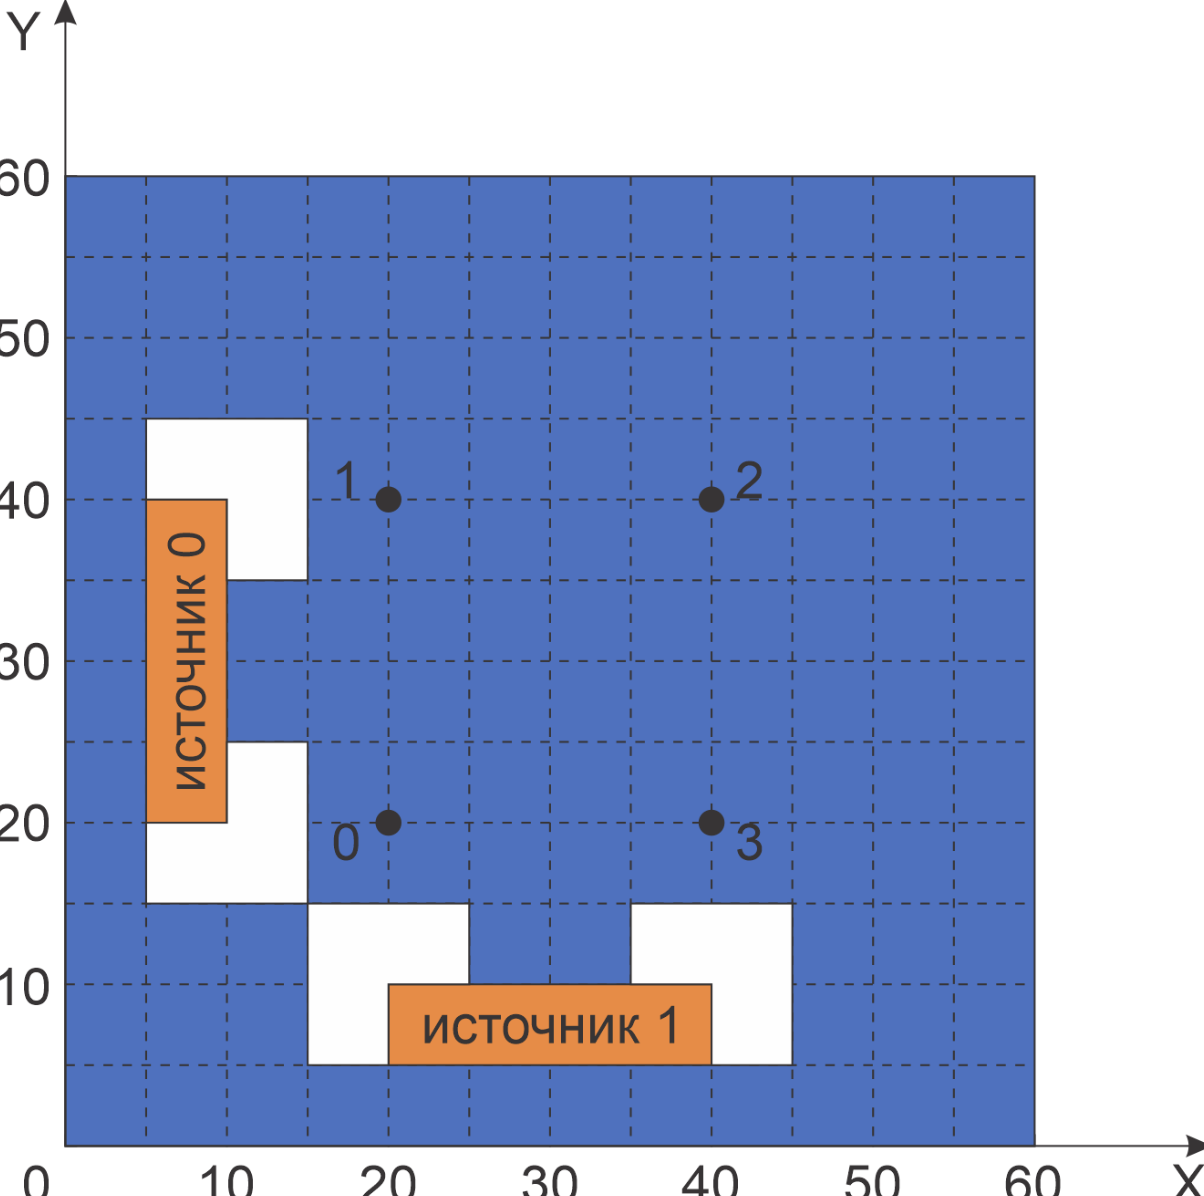

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from numba import njit, prange
import time

In [13]:
def diffusion_coef(N):
    """
    функция для создания матрицы коэффициентов диффузии

    параметры
    ---------
    N : int
        размер сетки (N x N)

    возвращает
    ----------
    np.ndarray
        матрица коэффициентов диффузии (N x N)
    """
    D = np.full((N, N), D0)
    for i in inclusions:
        x1 = int(i[0] * N / 60)
        x2 = int(i[1] * N / 60)
        y1 = int(i[2] * N / 60)
        y2 = int(i[3] * N / 60)

        D[y1 : y2, x1 : x2] = D1 #меняем коэффициент диффузии для включений

    return D

In [14]:
@njit(parallel=True)
def temperature(T, D, sources, dt, dx, t, N):
    """
    функция для вычисления поля температур после одного временного шага

    параметры
    ---------
    T : np.ndarray
        матрица N x N, текущее поле температур
    D : np.ndarray
        матрица коэффициентов диффузии N x N
    sources : list of tuples
        список из параметров источников
    dt : float
        временной шаг
    dx : float
        шаг по сетке
    t : float
        текущее время
    N : int
        размер сетки (N x N)

    возвращает
    ----------
    np.ndarray
        матрица со значениями температур
    """
    T1 = T.copy()

    T1[:, 0] = 0  #условие для ребра x = 0
    T1[0, :] = 0  #условие для ребра y = 0


    for i in prange(1, N - 1):
        for j in range(1, N - 1):
            #обновление температуры во внутренних точках поля
            #используя уравнение диффузии
            dTdx2 = (T[i + 1, j] - 2 * T[i, j] + T[i - 1, j]) / dx**2
            dTdy2 = (T[i, j + 1] - 2 * T[i, j] + T[i, j - 1]) / dx**2
            T1[i, j] += D[i, j] * (dTdx2 + dTdy2) * dt

    T1[:, -1] = T1[:, -2]  #абсолютная теплоизоляция на ребре x = N
    T1[-1, :] = T1[-2, :]  #абсолютная теплоизоляция на ребре y = N

    #обновление температуры внтури диапозонов источников
    for x1, x2, y1, y2, p, theta in sources:
        for j in range(int(y1 * N / 60), int(y2 * N / 60) + 1):
            for i in range(int(x1 * N / 60), int(x2 * N / 60) + 1):
                T1[j, i] += p * (np.sin(2 * np.pi * theta * t) + 1) * dt #учет закона изменения мощности источников
    return T1

In [18]:
def modeling(N, D0, t_m, T0, probes, sources):
    """
    функция для моделирования распространения тепла по пластине N x N

    параметры:
    -----------
    N : int
        размер сетки N x N
    D0 : float
        коэффициент диффузии основного материала (т.к. D0 > D1)
    t_m : float
        общее время моделирования
    T0 : float
        начальная температура
    probes : list of tuples
        список координат точек проб
    sources : list of tuples
        список источников тепла

    возвращает:
    ----------
    dict
        словарь результатов (финальное поле температур, температура в точках проб и время расчёта)
    """
    dx = 60 / N
    C = 0.2 #число Курранта
    dt = C * dx**2 / D0  #условие Курранта

    #начальные поля температур и коэффициентов диффузии
    T = np.full((N, N), T0)
    D = diffusion_coef(N)
    probe_res = {probe: [] for probe in probes}

    steps = int(t_m / dt) #количество временных шагов

    start_time = time.time() #запуск измерения времени расчета

    for step in range(steps):
        t = step * dt
        T = temperature(T, D, sources, dt, dx, t, N)

        #температура в точках проб на шаге step
        for probe in probes:
          x = int(probe[0] * N / 60)
          y = int(probe[0] * N / 60)
          probe_res[probe].append(T[y, x])

    end_time = time.time()
    lead_time = end_time - start_time  #время расчета
    print(f"при N = {N} время расчета = {lead_time:.2f} секунд")

    #сохранение матрицы и поля температур в файл
    np.save(f"T{N}.npy", T)
    np.save(f"probe_res{N}.npy", probe_res)

    return T, probe_res, lead_time

In [16]:
#коэффициенты из условия задачи

N_lst = [60, 120, 240, 480, 960] #размер массива поля температур
D0 = 1.0  #коэффициент диффузии основного материала
D1 = 0.01  #коэффициент диффузии включений
T0 = 0  #начальная температура
t_m = 600  #общее время моделирования

In [17]:
#параметры источников (x1, x2, y1, y2, p, theta)
sources = [(5, 10, 20, 40, 100, 37),
           (20, 40, 5, 10, 100, 73)]

#координаты включений (x1, x2, y1, y2)
inclusions = [(5, 15, 15, 25),
             (5, 15, 35, 45),
             (15, 25, 5, 15),
             (35, 45, 5, 15)]

#координаты четырех проб
probes = [(20, 20), (20, 40), (40, 40), (40, 20)]

In [8]:
results = {}
for N in N_lst:
  T, probe_res, lead_time = modeling(N, D0, t_m, T0, probes, sources)
  results[N] = {"T": T, "probe_res": probe_res, "lead_time": lead_time}

при N = 60 время расчета = 2.84 секунд
при N = 120 время расчета = 2.17 секунд
при N = 240 время расчета = 14.64 секунд
при N = 480 время расчета = 142.69 секунд
при N = 960 время расчета = 2186.96 секунд


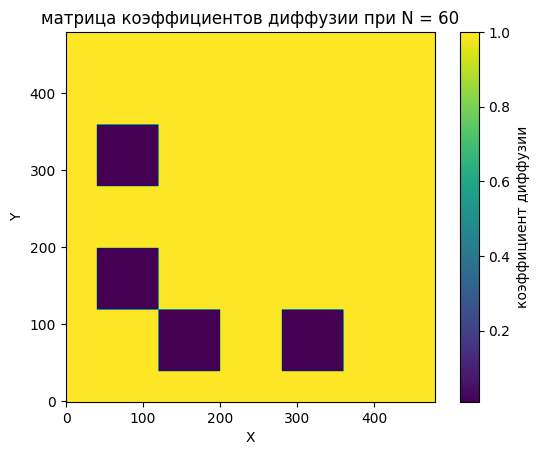

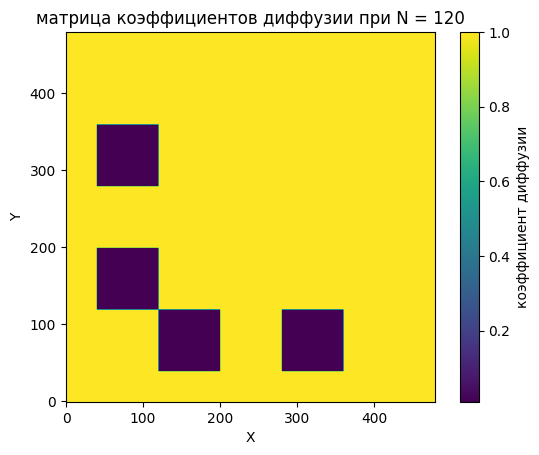

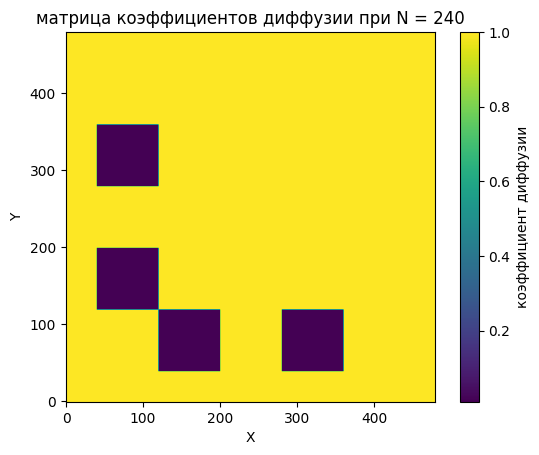

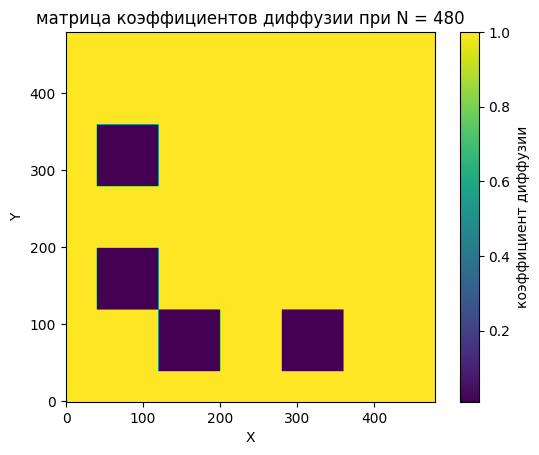

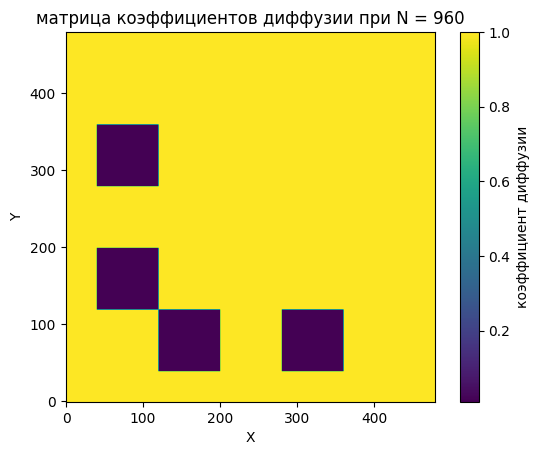

In [24]:
for N in N_lst:
  plt.figure()
  plt.imshow(D, cmap='viridis', origin='lower')
  plt.colorbar(label="коэффициент диффузии")
  plt.title(f"матрица коэффициентов диффузии при N = {N}")
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.savefig(f"diffusion{N}.png")

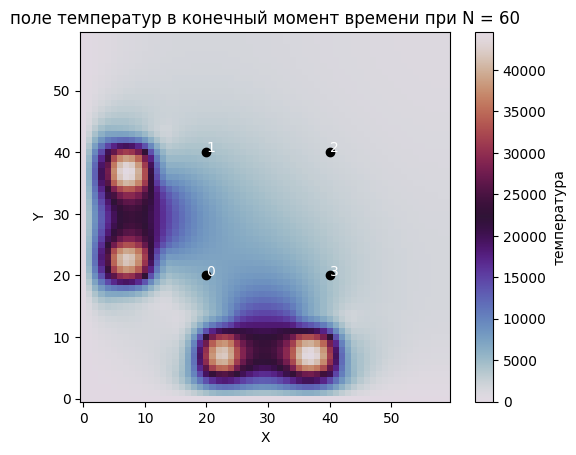

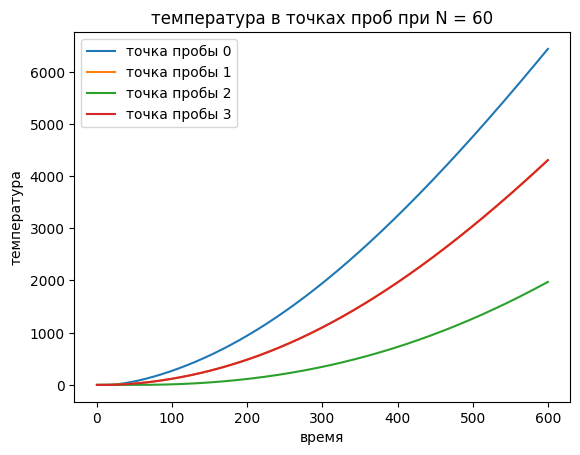

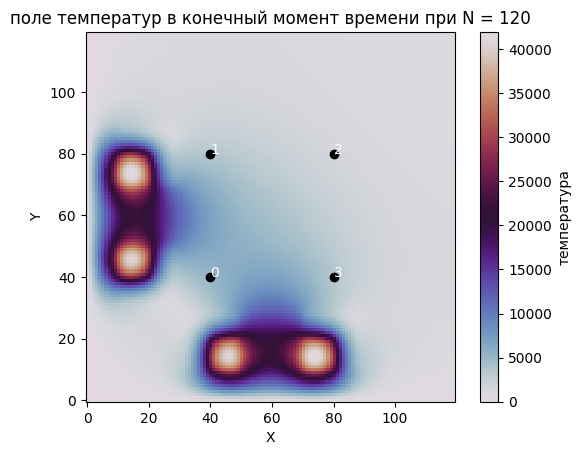

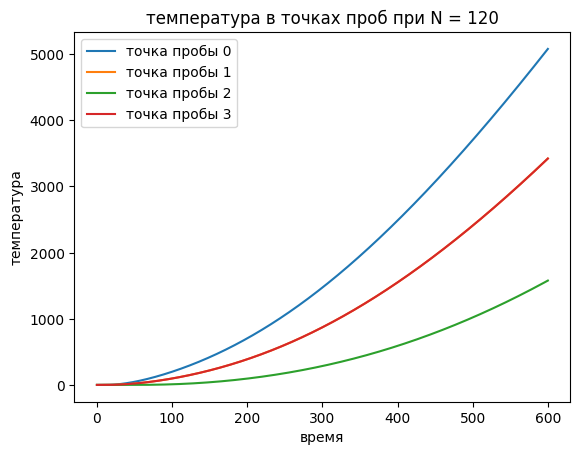

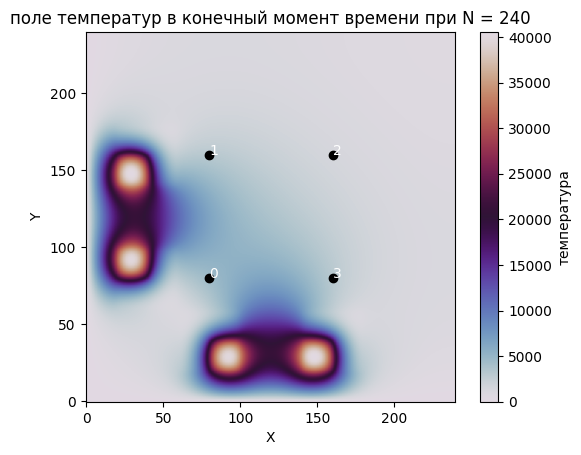

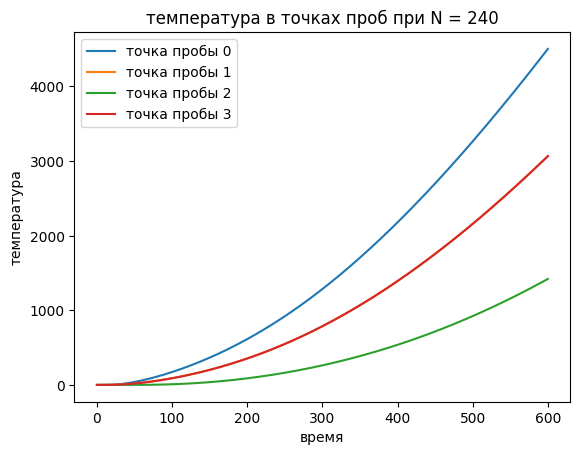

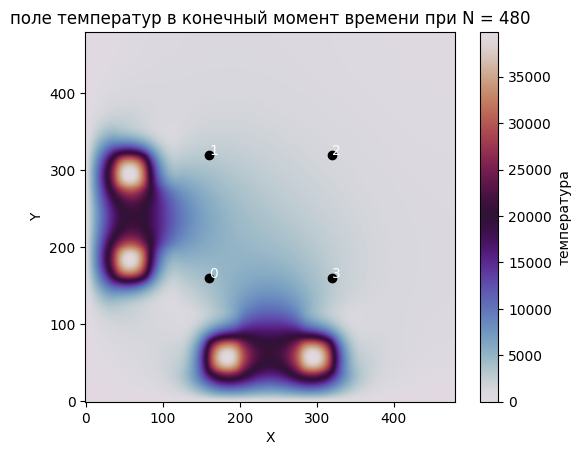

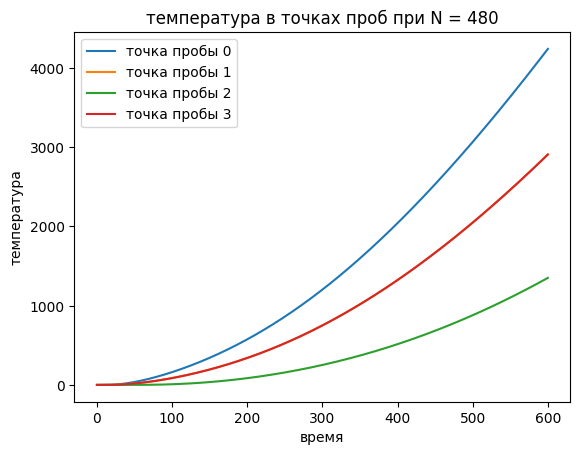

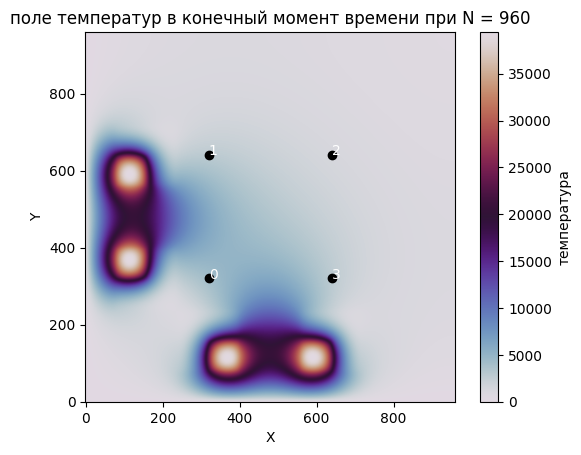

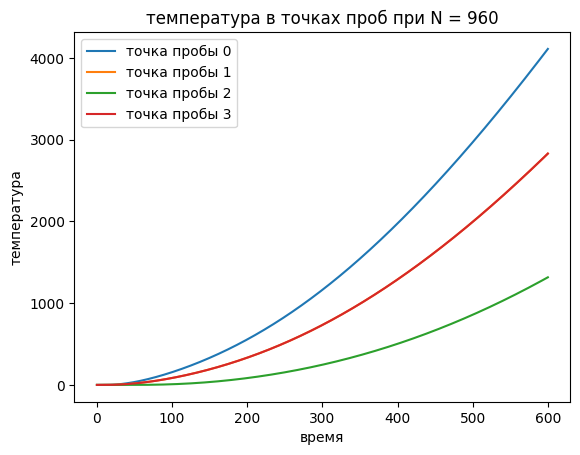

In [11]:
#цветовые карты
for N in N_lst:
    T = np.load(f"T{N}.npy")
    probe_res = np.load(f"probe_res{N}.npy", allow_pickle=True).item()

    plt.figure()
    plt.imshow(T, cmap='twilight', origin='lower')
    plt.colorbar(label="температура")
    plt.title(f"поле температур в конечный момент времени при N = {N}")
    plt.xlabel("X")
    plt.ylabel("Y")
    for i, (x, y) in enumerate(probes):
        plt.plot(int(x * N / 60), int(y * N / 60), 'ko')
        plt.text(int(x * N / 60), int(y * N / 60), str(i), color='black')
    plt.savefig(f"temperature_field{N}.png")

#графики температур в точках проб
    plt.figure()
    for i, probe in enumerate(probes):
        plt.plot(np.linspace(0, t_m, len(probe_res[probe])), probe_res[probe], label=f"точка пробы {i}")
    plt.title(f"температура в точках проб при N = {N}")
    plt.xlabel("время")
    plt.ylabel("температура")
    plt.legend()
    plt.savefig(f"temperature_probes{N}.png")

In [32]:
print(f"частота колебаний температуры")
for N in N_lst:
    dx = 60 / N
    C = 0.2
    dt = C * dx**2 / D0
    print(f"при N = {N}:")
    probe_res = results[N]["probe_res"]

    for i, probe in enumerate(probes):
        temps = probe_res[probe]
        fft_res = np.fft.rfft(temps)

        freqs = np.fft.rfftfreq(len(temps), d=dt)

        peaks, _ = find_peaks(np.abs(fft_res))

        if peaks.size > 0:
            dom_peak = np.argmax(np.abs(fft_res)[peaks])
            fr = freqs[peaks[dom_peak]]
        else:
            fr = 0.0

        print(f"    в точке пробы {i} {fr:.2f} Гц")

при N = 60:
    в точке пробы 0 106.67 Гц
    в точке пробы 1 100.69 Гц
    в точке пробы 2 33.28 Гц
    в точке пробы 3 90.88 Гц
при N = 120:
    в точке пробы 0 9.28 Гц
    в точке пробы 1 8.11 Гц
    в точке пробы 2 5.01 Гц
    в точке пробы 3 5.55 Гц
при N = 240:
    в точке пробы 0 2.80 Гц
    в точке пробы 1 2.45 Гц
    в точке пробы 2 1.20 Гц
    в точке пробы 3 2.00 Гц
при N = 480:
    в точке пробы 0 1.10 Гц
    в точке пробы 1 1.00 Гц
    в точке пробы 2 0.75 Гц
    в точке пробы 3 0.90 Гц
при N = 960:
    в точке пробы 0 0.50 Гц
    в точке пробы 1 0.45 Гц
    в точке пробы 2 0.35 Гц
    в точке пробы 3 0.40 Гц
